In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

In [2]:
df = pd.read_feather('pairs_data.feather')
df

,ratio,dist,id_1,pretty_formula_1,space_group_1,id_2,pretty_formula_2,space_group_2
0,5:3,0.075454,mp-31172,Ca5Ag3,I4/mcm,mp-571212,Yb5Ag3,I4/mcm
1,5:3,2.008706,mp-31172,Ca5Ag3,I4/mcm,mp-1501,Al3Pt5,Pbam
2,5:3,2.300419,mp-31172,Ca5Ag3,I4/mcm,mp-16514,Al3Ni5,Cmmm
3,5:3,1.506156,mp-31172,Ca5Ag3,I4/mcm,mp-10047,Ca5As3,P6_3/mcm
4,5:3,1.428876,mp-31172,Ca5Ag3,I4/mcm,mp-1106024,Eu5As3,P6_3/mcm
...,...,...,...,...,...,...,...,...
15063717,2:1:1,0.061459,mp-999137,SmTlSe2,R-3m,mp-1065514,YTlTe2,R-3m
15063718,2:1:1,2.728159,mp-999137,SmTlSe2,R-3m,mp-1187870,YTmTl2,Fm-3m
15063719,2:1:1,0.122831,mp-1008561,TmTlTe2,R-3m,mp-1065514,YTlTe2,R-3m
15063720,2:1:1,2.711075,mp-1008561,TmTlTe2,R-3m,mp-1187870,YTmTl2,Fm-3m


In [3]:
import torch
import torch.nn.functional as F
from data import collate_batch, comp2graph

device = 'cuda'
torch.set_default_device(device)

In [4]:
benchmark = pd.read_csv('https://raw.githubusercontent.com/usccolumbia/cspbenchmark/main/data/CSPbenchmark_test_data.csv')
benchmark_ids = benchmark['material_id']

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, IterableDataset
from tqdm import trange

regen = False

tau = 1.0
val_frac = 0.1
batch_size = 1024
df_train = df.iloc[::16].query('dist > 0.01')
print(df_train.shape)
df_train = df_train.query('id_1 not in @benchmark_ids and id_2 not in @benchmark_ids')
print(df_train.shape)
df_train = df_train.iloc[:-(df_train.shape[0] % batch_size)]
print(df_train.shape)
print((df_train['dist'] < tau).mean())

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X1, X2, y, tau):
        self.X1 = X1
        self.X2 = X2
        self.y = y
        self.tau = tau
    def __len__(self):
        return len(self.X1)
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx] < self.tau

if regen:
    X1 = []
    X2 = []
    y = []
    for i in trange(0, len(df_train.index), batch_size):
        df_batch = df_train.iloc[i:i+batch_size]
        X1.append(collate_batch([comp2graph(x) for x in df_batch['pretty_formula_1']]))
        X2.append(collate_batch([comp2graph(x) for x in df_batch['pretty_formula_2']]))
        y.append(torch.tensor(df_batch['dist'].values) < tau)

    ds = MyDataset(X1, X2, y, tau)

    torch.save(ds, 'ds.pt')
else:
    ds = torch.load('ds.pt', weights_only=False)
    

train_ds, val_ds = random_split(ds, [1 - val_frac, val_frac], generator=torch.Generator(device=device).manual_seed(123))
train_dl = DataLoader(train_ds, batch_size=None, shuffle=True, generator=torch.Generator(device=device))
val_dl = DataLoader(val_ds, batch_size=None)
val_X1, val_X2, val_y = next(iter(val_dl))

(745873, 8)
(739604, 8)
(739328, 8)
0.10681186158240998


In [7]:
lr = 3e-3  # 1 * 10^-3 0.001
num_epochs = 20
elem_embed_dim: int = 64
comp_embed_dim: int = 64

Train: 0.251 Valid: 0.279: 100%|██████████| 13000/13000 [06:41<00:00, 32.34it/s]


<Axes: xlabel='Epoch', ylabel='Train Loss'>

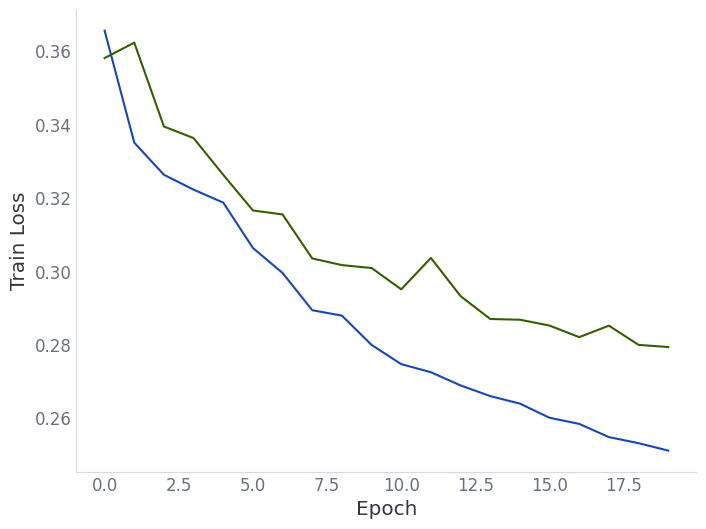

In [8]:
from tqdm import trange
from model import CompositionEmbedding

hist = []
# model = CompositionEmbedding(elem_hidden_dim=elem_embed_dim, comp_embed_dim=comp_embed_dim)
model = torch.load('checkpoints/larger.pt', weights_only=False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_epochs)

with trange(num_epochs * len(train_dl)) as bar:
    for epoch in range(num_epochs):
        model.train()
        loss_vals = []
        for X1, X2, y in train_dl:
            bar.update()
            optimizer.zero_grad()
            loss_val = F.binary_cross_entropy(model(X1, X2), y.float())
            loss_val.backward()
            optimizer.step()
            loss_vals.append(loss_val.detach().item())
            if (bar.n + 1) % 100 == 0:
                bar.set_description_str('Train: {:.3f} Valid: {:.3f}'.format(loss_vals[-1],  hist[-1]["Validation Loss"] if hist else 0))
        model.eval()
        with torch.no_grad():
            val_losses = []
            for X1, X2, y in val_dl:
                val_losses.append(F.binary_cross_entropy(model(X1, X2), y.float()))

            val_losses = torch.tensor(val_losses)
        hist.append({
            'Epoch': epoch,
            'Train Loss': sum(loss_vals) / len(loss_vals),
            'Validation Loss': val_losses.mean().item()
        })

        bar.set_description_str('Train: {:.3f} Valid: {:.3f}'.format(hist[-1]["Train Loss"], hist[-1]["Validation Loss"]))
        scheduler.step()

hist = pd.DataFrame(hist)

sns.lineplot(hist, x='Epoch', y='Train Loss')
sns.lineplot(hist, x='Epoch', y='Validation Loss')

In [9]:
ypred = []
ytrue = []
for X1, X2, y in val_dl:
    ypred.append(model(X1, X2))
    ytrue.append(y)

ypred = torch.cat(ypred)
ytrue = torch.cat(ytrue)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.59 GiB of which 13.44 MiB is free. Including non-PyTorch memory, this process has 23.55 GiB memory in use. Of the allocated memory 22.94 GiB is allocated by PyTorch, and 310.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
((ypred > 0.5) == ytrue).float().mean()

tensor(0.8925, device='cuda:0')

In [ ]:
dists = torch.linalg.vector_norm(model.embed(X1) - model.embed(X2), dim=1).numpy(force=True)
y_np = y.numpy(force=True)

sns.histplot(x=dists[y_np], label='y = 1', fill=False, element='step', bins=20)
sns.histplot(x=dists[~y_np], label='y = 0', fill=False, element='step', bins=20)
plt.legend()

- train from CIF folder
- oxidation state (BERTOS), make nodes

In [ ]:
mp_id = 'mp-2731'

df_id = df.query('id_1 == @mp_id')

X1 = collate_batch([comp2graph(df_id['pretty_formula_1'].iloc[0])])

x2s = df_id['pretty_formula_2']

X2 = []
for i in range(0, x2s.shape[0], batch_size):
    X2.append(collate_batch([comp2graph(c) for c in x2s.iloc[i:i+batch_size]]))

model.eval()
z1 = model.embed(X1)
z2 = torch.cat([model.embed(x) for x in X2])

dists = torch.cdist(z1, z2)
df_id['z_dist'] = dists.numpy(force=True).reshape(-1)

In [ ]:
df_id.sort_values('z_dist')

In [ ]:
torch.save(model, 'checkpoints/larger-2.pt')